In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


In [2]:
df = pd.read_csv("fake_job_postings.csv")

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
# dataset balance check

df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

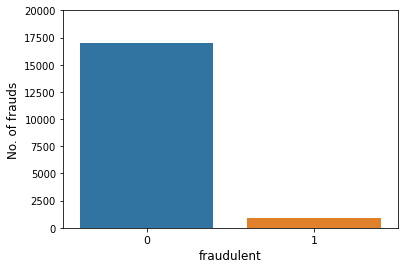

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x = 'fraudulent')
plt.xlabel("fraudulent", fontsize=12)
plt.ylabel("No. of frauds", fontsize=12)
plt.ylim(0,20000)
plt.xticks([0,1],['0','1'], fontsize=11)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, "Bachelor's Degree"),
  Text(1, 0, "Master's Degree"),
  Text(2, 0, 'High School or equivalent'),
  Text(3, 0, 'Unspecified'),
  Text(4, 0, 'Some College Coursework Completed'),
  Text(5, 0, 'Vocational'),
  Text(6, 0, 'Certification'),
  Text(7, 0, 'Associate Degree'),
  Text(8, 0, 'Professional'),
  Text(9, 0, 'Doctorate'),
  Text(10, 0, 'Some High School Coursework'),
  Text(11, 0, 'Vocational - Degree'),
  Text(12, 0, 'Vocational - HS Diploma')])

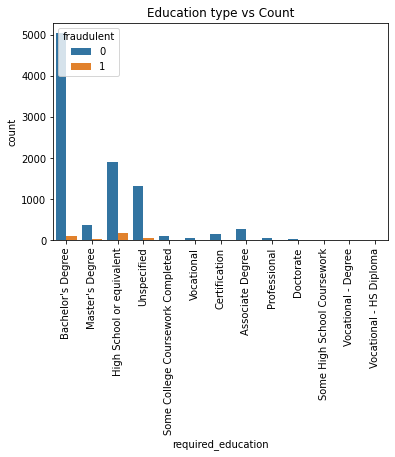

In [8]:
sns.countplot(x="required_education",data=df, hue = "fraudulent")
plt.title("Education type vs Count")
plt.xticks(rotation=90)

In [9]:
# clean education

df['required_education'] = df['required_education'].replace({'Vocational':'Others',
                             'Certification':'Others',
                             'Associate Degree':'Others',
                             'Professional':'Others',
                             'Some High School Coursework':'Others',
                             'Some College Coursework Completed':'Others',
                             'Vocational - Degree':'Others',
                             'Vocational - HS Diploma':'Others',
                             "Master's Degree":"Master's Degree and Doctorate",   
                             'Doctorate':"Master's Degree and Doctorate",
                             "Bachelor's Degree" :"Bachelor's Degree",
                             "Bachelor's Degree" :"Bachelor's Degree",
                             'High School or equivalent':'Others',
                             np.nan:'Unspecified'})

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Unspecified'),
  Text(1, 0, "Bachelor's Degree"),
  Text(2, 0, "Master's Degree and Doctorate"),
  Text(3, 0, 'Others')])

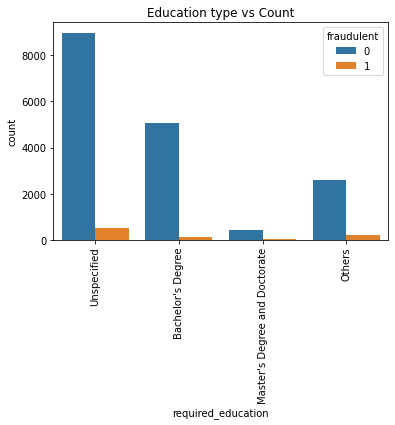

In [10]:
sns.countplot(x="required_education",data=df, hue = "fraudulent")
plt.title("Education type vs Count")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Internship'),
  Text(1, 0, 'Not Applicable'),
  Text(2, 0, 'Mid-Senior level'),
  Text(3, 0, 'Associate'),
  Text(4, 0, 'Entry level'),
  Text(5, 0, 'Executive'),
  Text(6, 0, 'Director')])

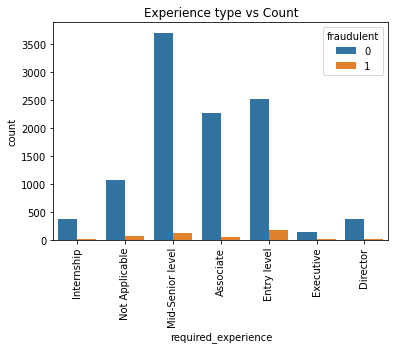

In [11]:
sns.countplot(x="required_experience",data=df, hue = "fraudulent")
plt.title("Experience type vs Count")
plt.xticks(rotation=90)

In [12]:
# clean experience

df['required_experience'] = df['required_experience'].replace({'Internship':'Internship/Entry level/Unspecified',
                             'Entry level':'Internship/Entry level/Unspecified',
                             'Not Applicable':'Internship/Entry level/Unspecified',
                             'Mid-Senior level':'Mid-Senior level',
                             'Associate':'Mid-Senior level',
                             'Executive':'Executive',
                             'Director':'Director',
                             np.nan:'Internship/Entry level/Unspecified'})

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Internship/Entry level/Unspecified'),
  Text(1, 0, 'Mid-Senior level'),
  Text(2, 0, 'Executive'),
  Text(3, 0, 'Director')])

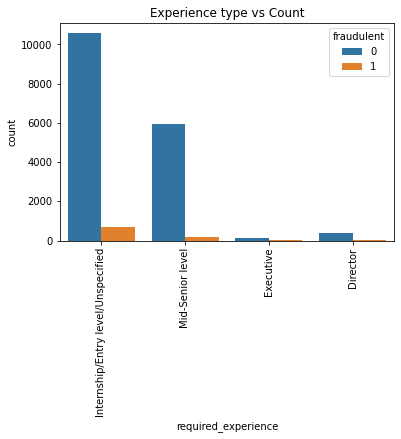

In [13]:
sns.countplot(x="required_experience",data=df, hue = "fraudulent")
plt.title("Experience type vs Count")
plt.xticks(rotation=90)

In [14]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience        0
required_education         0
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [15]:
# clean employment type

df['employment_type'].value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [16]:
df['employment_type'] = df['employment_type'].fillna('missing')
df.loc[df['employment_type'].str.contains('Full-time',case=False), 'employment_type'] = 'ft'
df.loc[df['employment_type'].str.contains('Contract',case=False), 'employment_type'] = 'non_ft'
df.loc[df['employment_type'].str.contains('Part-time',case=False), 'employment_type'] = 'non_ft'
df.loc[df['employment_type'].str.contains('Temporary',case=False), 'employment_type'] = 'non_ft'
df.loc[df['employment_type'].str.contains('Other',case=False), 'employment_type'] = 'non_ft'
df['employment_type'].value_counts()

ft         11620
missing     3471
non_ft      2789
Name: employment_type, dtype: int64

In [17]:
# Clean job title

df.loc[df['title'].str.contains('Accountant',case=False), 'Role'] = 'Accountant'
df.loc[df['title'].str.contains('Administrator',case=False), 'Role'] = 'Administrator/Administrative'
df.loc[df['title'].str.contains('Admin',case=False), 'Role'] = 'Administrator/Administrative'
df.loc[df['title'].str.contains('Administrative',case=False), 'Role'] = 'Administrator/Administrative'
df.loc[df['title'].str.contains('Assistant',case=False), 'Role'] = 'Assistant'
df.loc[df['title'].str.contains('Agent',case=False), 'Role'] = 'Agent'
df.loc[df['title'].str.contains('Analyst',case=False), 'Role'] = 'Analyst'
df.loc[df['title'].str.contains('Architect',case=False), 'Role'] = 'Architect'
df.loc[df['title'].str.contains('Artist',case=False), 'Role'] = 'Artist'
df.loc[df['title'].str.contains('Adviser',case=False), 'Role'] = 'Consultant/Adviser'
df.loc[df['title'].str.contains('Advisor',case=False), 'Role'] = 'Consultant/Adviser'
df.loc[df['title'].str.contains('Associate',case=False), 'Role'] = 'Associate'
df.loc[df['title'].str.contains('Auditor',case=False), 'Role'] = 'Auditor'
df.loc[df['title'].str.contains('Chef',case=False), 'Role'] = 'Chef'
df.loc[df['title'].str.contains('Clerk',case=False), 'Role'] = 'Clerk'
df.loc[df['title'].str.contains('Cleaner',case=False), 'Role'] = 'Cleaner'
df.loc[df['title'].str.contains('Coach',case=False), 'Role'] = 'Coach/Instructor'
df.loc[df['title'].str.contains('Consultant',case=False), 'Role'] = 'Consultant/Adviser'
df.loc[df['title'].str.contains('Counselor',case=False), 'Role'] = 'Counselor'
df.loc[df['title'].str.contains('Counsel',case=False), 'Role'] = 'Counselor'
df.loc[df['title'].str.contains('Coordinator',case=False), 'Role'] = 'Coordinator'
df.loc[df['title'].str.contains('Developer',case=False), 'Role'] = 'Developer'
df.loc[df['title'].str.contains('Designer',case=False), 'Role'] = 'Designer'
df.loc[df['title'].str.contains('Director',case=False), 'Role'] = 'Director'
df.loc[df['title'].str.contains('Driver',case=False), 'Role'] = 'Driver'
df.loc[df['title'].str.contains('Data Entry',case=False), 'Role'] = 'Data Entry'
df.loc[df['title'].str.contains('Engineer',case=False), 'Role'] = 'Engineer'
df.loc[df['title'].str.contains('Executive',case=False), 'Role'] = 'Executive'
df.loc[df['title'].str.contains('Electrician',case=False), 'Role'] = 'Electrician/Machinist'
df.loc[df['title'].str.contains('Machinist',case=False), 'Role'] = 'Electrician/Machinist'
df.loc[df['title'].str.contains('Estimator',case=False), 'Role'] = 'Estimator'
df.loc[df['title'].str.contains('Expert',case=False), 'Role'] = 'Expert'
df.loc[df['title'].str.contains('Head',case=False), 'Role'] = 'Head/Lead'
df.loc[df['title'].str.contains('Lead',case=False), 'Role'] = 'Head/Lead'
df.loc[df['title'].str.contains('Instructor',case=False), 'Role'] = 'Coach/Instructor'
df.loc[df['title'].str.contains('Intern',case=False), 'Role'] = 'Intern/Trainee'
df.loc[df['title'].str.contains('Trainee',case=False), 'Role'] = 'Intern/Trainee'
df.loc[df['title'].str.contains('Laborer',case=False), 'Role'] = 'Operator/Laborer'
df.loc[df['title'].str.contains('Manager',case=False), 'Role'] = 'Manager'
df.loc[df['title'].str.contains('Merchandiser',case=False), 'Role'] = 'Merchandiser'
df.loc[df['title'].str.contains('Marketer',case=False), 'Role'] = 'Marketer'
df.loc[df['title'].str.contains('Nurse',case=False), 'Role'] = 'Nurse'
df.loc[df['title'].str.contains('Nanny',case=False), 'Role'] = 'Nanny/Caregiver/Housekeeper'
df.loc[df['title'].str.contains('Caregiver',case=False), 'Role'] = 'Nanny/Caregiver/Housekeeper'
df.loc[df['title'].str.contains('Housekeeper',case=False), 'Role'] = 'Nanny/Caregiver/Housekeeper'
df.loc[df['title'].str.contains('Operator',case=False), 'Role'] = 'Operator/Laborer'
df.loc[df['title'].str.contains('Officer',case=False), 'Role'] = 'Officer'
df.loc[df['title'].str.contains('Optician',case=False), 'Role'] = 'Optician'
df.loc[df['title'].str.contains('Planner',case=False), 'Role'] = 'Planner'
df.loc[df['title'].str.contains('Professional',case=False), 'Role'] = 'Professional'
df.loc[df['title'].str.contains('Producer',case=False), 'Role'] = 'Producer'
df.loc[df['title'].str.contains('Programmer',case=False), 'Role'] = 'Programmer'
df.loc[df['title'].str.contains('Purchaser',case=False), 'Role'] = 'Purchaser'
df.loc[df['title'].str.contains('Quality Assurance',case=False), 'Role'] = 'Quality Assurance'
df.loc[df['title'].str.contains('Receptionist',case=False), 'Role'] = 'Receptionist'
df.loc[df['title'].str.contains('Recruiter',case=False), 'Role'] = 'Recruiter'
df.loc[df['title'].str.contains('Representative',case=False), 'Role'] = 'Representative'
df.loc[df['title'].str.contains('Rep',case=False), 'Role'] = 'Representative'
df.loc[df['title'].str.contains('Specialist',case=False), 'Role'] = 'Specialist'
df.loc[df['title'].str.contains('Supervisor',case=False), 'Role'] = 'Supervisor'
df.loc[df['title'].str.contains('Strategist',case=False), 'Role'] = 'Strategist'
df.loc[df['title'].str.contains('Scientist',case=False), 'Role'] = 'Scientist'
df.loc[df['title'].str.contains('Teacher',case=False), 'Role'] = 'Teacher'
df.loc[df['title'].str.contains('Technician',case=False), 'Role'] = 'Technician'
df.loc[df['title'].str.contains('Therapist',case=False), 'Role'] = 'Therapist'
df.loc[df['title'].str.contains('Tester',case=False), 'Role'] = 'Tester'
df.loc[df['title'].str.contains('Editor',case=False), 'Role'] = 'Editor/Writer'
df.loc[df['title'].str.contains('Vice President',case=False), 'Role'] = 'Vice President'
df.loc[df['title'].str.contains('VP',case=False), 'Role'] = 'Vice President'
df.loc[df['title'].str.contains('Writer',case=False), 'Role'] = 'Editor/Writer'
df.loc[df['title'].str.contains('URGENT',case=False), 'Role'] = 'URGENT'

df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Role
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,non_ft,Internship/Entry level/Unspecified,Unspecified,NaN,Marketing,0,Intern/Trainee
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,ft,Internship/Entry level/Unspecified,Unspecified,Marketing and Advertising,Customer Service,0,NaN
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,missing,Internship/Entry level/Unspecified,Unspecified,NaN,NaN,0,Assistant
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,ft,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Executive
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,ft,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Manager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,ft,Mid-Senior level,Unspecified,Computer Software,Sales,0,Director
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,ft,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,Accountant
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,ft,Internship/Entry level/Unspecified,Unspecified,NaN,NaN,0,Engineer
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,non_ft,Internship/Entry level/Unspecified,Others,Graphic Design,Design,0,Designer


In [18]:
df['Role'] = df['Role'].replace(np.nan, 'Other')
df=df.drop('title',1)


Role = df['Role'].value_counts()
Role

/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1808757172.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop('title',1)


Other                           2262
Manager                         2218
Developer                       1731
Engineer                        1602
Teacher                          779
Representative                   766
Associate                        604
Intern/Trainee                   582
Head/Lead                        569
Designer                         550
Specialist                       542
Assistant                        470
Executive                        458
Director                         433
Analyst                          402
Consultant/Adviser               400
Administrator/Administrative     330
Technician                       239
Editor/Writer                    232
Coordinator                      206
Driver                           160
Supervisor                       160
Agent                            153
Professional                     146
Officer                          145
Nanny/Caregiver/Housekeeper      136
Data Entry                       113
A

In [19]:
df.isnull().sum()

job_id                     0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                4903
function                6455
fraudulent                 0
Role                       0
dtype: int64

In [20]:
# company_profile, description, requirements, benefits, industry and function are combined for topic modelling. drop these variables in dataset

df=df.drop(['company_profile','description','requirements','benefits','industry','function'],1)

# remove variables not used in the analysis: department, salary_range, location

df=df.drop(['department','salary_range','location'],1)

df


/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1361615135.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop(['company_profile','description','requirements','benefits','industry','function'],1)
/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1361615135.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop(['department','salary_range','location'],1)


,job_id,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,Role
0,1,0,1,0,non_ft,Internship/Entry level/Unspecified,Unspecified,0,Intern/Trainee
1,2,0,1,0,ft,Internship/Entry level/Unspecified,Unspecified,0,Other
2,3,0,1,0,missing,Internship/Entry level/Unspecified,Unspecified,0,Assistant
3,4,0,1,0,ft,Mid-Senior level,Bachelor's Degree,0,Executive
4,5,0,1,1,ft,Mid-Senior level,Bachelor's Degree,0,Manager
...,...,...,...,...,...,...,...,...,...
17875,17876,0,1,1,ft,Mid-Senior level,Unspecified,0,Director
17876,17877,0,1,1,ft,Mid-Senior level,Bachelor's Degree,0,Accountant
17877,17878,0,0,0,ft,Internship/Entry level/Unspecified,Unspecified,0,Engineer
17878,17879,0,0,1,non_ft,Internship/Entry level/Unspecified,Others,0,Designer


In [21]:
#import topic modeling features and missing values features

topic_modeling = pd.read_csv("topicmodels17.csv")
missing_values= pd.read_csv("missingvalues.csv")

# combine all features

data=pd.concat([topic_modeling,missing_values,df],axis=1)

data

,job_id,1,2,3,4,5,6,7,8,9,...,miss.fraudulent,job_id,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,Role
0,1.0,0.099123,0.065973,0.027299,0.038349,0.032824,0.038349,0.093598,0.016250,0.049399,...,0,1,0,1,0,non_ft,Internship/Entry level/Unspecified,Unspecified,0,Intern/Trainee
1,2.0,0.033585,0.043720,0.026828,0.050477,0.016693,0.094396,0.209261,0.077504,0.084261,...,0,2,0,1,0,ft,Internship/Entry level/Unspecified,Unspecified,0,Other
2,3.0,0.054228,0.046415,0.046415,0.124540,0.038603,0.054228,0.030790,0.022978,0.030790,...,0,3,0,1,0,missing,Internship/Entry level/Unspecified,Unspecified,0,Assistant
3,4.0,0.066698,0.082446,0.066698,0.023390,0.047013,0.050950,0.054887,0.125753,0.023390,...,0,4,0,1,0,ft,Mid-Senior level,Bachelor's Degree,0,Executive
4,5.0,0.043829,0.053633,0.038927,0.078143,0.053633,0.043829,0.068339,0.019319,0.019319,...,0,5,0,1,1,ft,Mid-Senior level,Bachelor's Degree,0,Manager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17877.0,0.020503,0.028802,0.120088,0.049548,0.140835,0.016353,0.049548,0.057847,0.066146,...,0,17876,0,1,1,ft,Mid-Senior level,Unspecified,0,Director
17876,17878.0,0.096807,0.016807,0.033950,0.068235,0.022521,0.091092,0.016807,0.016807,0.016807,...,0,17877,0,1,1,ft,Mid-Senior level,Bachelor's Degree,0,Accountant
17877,17879.0,0.028835,0.028835,0.028835,0.068051,0.048443,0.224913,0.058247,0.028835,0.097463,...,0,17878,0,0,0,ft,Internship/Entry level/Unspecified,Unspecified,0,Engineer
17878,17880.0,0.015456,0.058593,0.062514,0.038985,0.019377,0.027220,0.050750,0.070358,0.376240,...,0,17879,0,0,1,non_ft,Internship/Entry level/Unspecified,Others,0,Designer


In [22]:
# drop job_id from the dataset

data=data.drop(['job_id','miss.job_id'],1)


/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1279429311.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop(['job_id','miss.job_id'],1)


In [23]:
data.isnull().sum()

1                            1
2                            1
3                            1
4                            1
5                            1
6                            1
7                            1
8                            1
9                            1
10                           1
11                           1
12                           1
13                           1
14                           1
15                           1
16                           1
17                           1
miss.title                   0
miss.location                0
miss.department              0
miss.salary_range            0
miss.company_profile         0
miss.description             0
miss.requirements            0
miss.benefits                0
miss.telecommuting           0
miss.has_company_logo        0
miss.has_questions           0
miss.employment_type         0
miss.required_experimence    0
miss.required_education      0
miss.industry                0
miss.fun

In [24]:
#id 17514 has no text fields -->drop id17514 as replacement with 0 has some meaning to topic modeling

# data=data.drop(data.index[17513])
data=data[:-1]
data.isnull().sum()

1                            0
2                            0
3                            0
4                            0
5                            0
6                            0
7                            0
8                            0
9                            0
10                           0
11                           0
12                           0
13                           0
14                           0
15                           0
16                           0
17                           0
miss.title                   0
miss.location                0
miss.department              0
miss.salary_range            0
miss.company_profile         0
miss.description             0
miss.requirements            0
miss.benefits                0
miss.telecommuting           0
miss.has_company_logo        0
miss.has_questions           0
miss.employment_type         0
miss.required_experimence    0
miss.required_education      0
miss.industry                0
miss.fun

In [25]:
# Adding Dummies to categorical features

data = pd.concat([data, pd.get_dummies(data.employment_type, prefix='employment')], axis=1)
data = pd.concat([data, pd.get_dummies(data.required_experience, prefix='experience')], axis=1)
data = pd.concat([data, pd.get_dummies(data.required_education, prefix='education')], axis=1)

# drop employment_type, required_experience, required_education, Role from the dataset
data=data.drop(['employment_type','required_experience','required_education','Role'],1)

/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1820560608.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop(['employment_type','required_experience','required_education','Role'],1)


In [26]:
data.to_csv('final_dataset_for_modeling.CSV')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17879 entries, 0 to 17878
Data columns (total 49 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   1                                              17879 non-null  float64
 1   2                                              17879 non-null  float64
 2   3                                              17879 non-null  float64
 3   4                                              17879 non-null  float64
 4   5                                              17879 non-null  float64
 5   6                                              17879 non-null  float64
 6   7                                              17879 non-null  float64
 7   8                                              17879 non-null  float64
 8   9                                              17879 non-null  float64
 9   10                                             178

In [27]:
# explore is miss.xxx features are important
# models: - logistic regression (ZJ); naïve baysian (Mansi); random forest (ZJ); boosting-light GBM (Mansi); LSTM (ZJ); BERT (Mansi); Hierarchal clustering (ZJ, to explore if got time) 

X = data.drop('fraudulent',1)
y = data.fraudulent


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.30, random_state = 0)

print('Shape of X_train =', X_train.shape, ' and shape of y_train = ', y_train.shape)
print('Shape of X_test =', X_test.shape, ' and shape of y_test = ', y_test.shape)


Shape of X_train = (12515, 48)  and shape of y_train =  (12515,)
Shape of X_test = (5364, 48)  and shape of y_test =  (5364,)


/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/ipykernel_30671/1675138454.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data.drop('fraudulent',1)


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12515 entries, 17258 to 4466
Data columns (total 48 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   1                                              12515 non-null  float64
 1   2                                              12515 non-null  float64
 2   3                                              12515 non-null  float64
 3   4                                              12515 non-null  float64
 4   5                                              12515 non-null  float64
 5   6                                              12515 non-null  float64
 6   7                                              12515 non-null  float64
 7   8                                              12515 non-null  float64
 8   9                                              12515 non-null  float64
 9   10                                             

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

nbm = GaussianNB()
nbm_fit = nbm.fit(X_train,y_train)
best_predictions = nbm_fit.predict(X_test)

# # print('Gaussian Naive Bayes Performance: Flow %d'%(i+1))
# # print('---------------------------------')
# # print('Accuracy        : ', metrics.accuracy_score(y_test_list[i], nbm_pred))
# # print('F1 Score        : ', metrics.f1_score(y_test_list[i], nbm_pred))
# # print('Precision       : ', metrics.precision_score(y_test_list[i], nbm_pred))
# # print('Recall          : ', metrics.recall_score(y_test_list[i], nbm_pred))
# # # print('Confusion Matrix:\n ', confusion_matrix(y_test_list[i], nbm_pred))

# Logreg=LogisticRegression()
# LR_fit=Logreg.fit(X_train,y_train)
# best_predictions = Logreg.predict(X_test)

# print classification report 
print(classification_report(y_test, best_predictions)) 

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5104
           1       0.16      0.69      0.26       260

    accuracy                           0.81      5364
   macro avg       0.57      0.75      0.58      5364
weighted avg       0.94      0.81      0.86      5364



In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, best_predictions)

0.8102162565249813

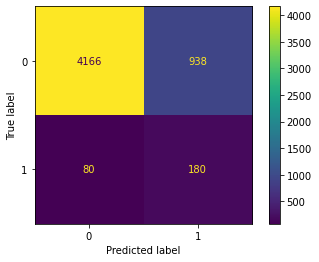

accuracy=0.8102162565249813
precision=0.16100178890876565
TPR=0.6923076923076923
TNR=0.8162225705329154


In [31]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, best_predictions, labels=nbm_fit.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nbm_fit.classes_)
disp.plot()
plt.show()

[[tn, fp], [fn, tp]] =cm


accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)

print('accuracy={}'.format(accuracy))
print('precision={}'.format(precision))
print('TPR={}'.format(TPR))
print('TNR={}'.format(TNR))

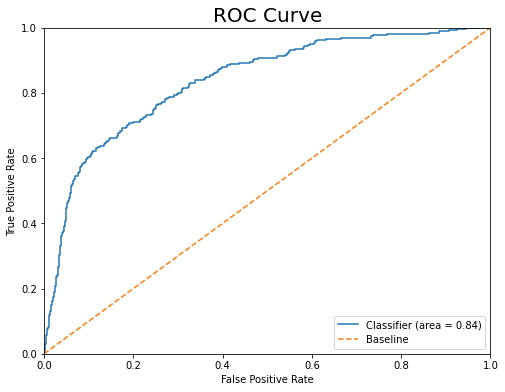

In [32]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Calculate class probabilities, generate ROC curve, and compute AUC
y_proba=nbm_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
classifier_roc_auc = roc_auc_score(y_test, y_proba)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % classifier_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve',fontsize = "20")
plt.legend(loc="lower right")
plt.show()

In [33]:
from imblearn.over_sampling import SMOTE 

In [34]:
# Use SMOTE to handle unbalanced data in train set

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (12515, 48)
Shape of X after SMOTE: (23818, 48)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraudulent, dtype: float64

In [35]:
print('\nBalance of positive and negative Revenue classes for training set (%):')
y_train_sm.value_counts(normalize=True) * 100


Balance of positive and negative Revenue classes for training set (%):


0    50.0
1    50.0
Name: fraudulent, dtype: float64

In [36]:
nbm = GaussianNB()
nbm_fit = nbm.fit(X_train_sm,y_train_sm)
best_predictions_sm = nbm_fit.predict(X_test)

# print classification report 
print(classification_report(y_test, best_predictions_sm)) 

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      5104
           1       0.13      0.75      0.22       260

    accuracy                           0.75      5364
   macro avg       0.56      0.75      0.54      5364
weighted avg       0.94      0.75      0.82      5364



In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, best_predictions_sm)

0.7470171513795675

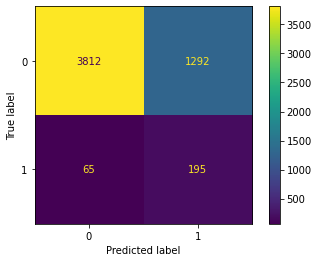

accuracy=0.7470171513795675
precision=0.13113651647612642
TPR=0.75
TNR=0.7468652037617555


In [38]:
cm = confusion_matrix(y_test, best_predictions_sm, labels=nbm_fit.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nbm_fit.classes_)
disp.plot()
plt.show()

[[tn, fp], [fn, tp]] =cm


accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)

print('accuracy={}'.format(accuracy))
print('precision={}'.format(precision))
print('TPR={}'.format(TPR))
print('TNR={}'.format(TNR))

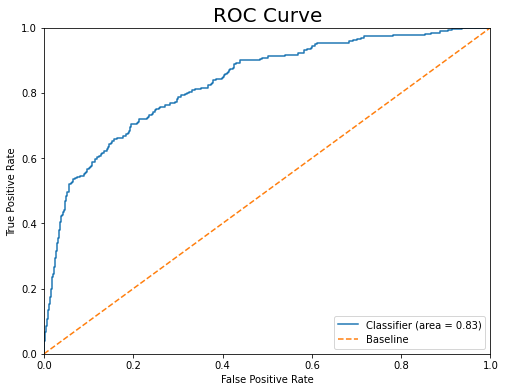

In [39]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Calculate class probabilities, generate ROC curve, and compute AUC
y_proba_sm=nbm_fit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_sm)
classifier_roc_auc = roc_auc_score(y_test, y_proba_sm)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % classifier_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve',fontsize = "20")
plt.legend(loc="lower right")
plt.show()